# Series temporales

Las series temporales son **secuencias de datos ordenadas cronológicamente** que registran la evolución de una variable a lo largo del tiempo. Se pueden analizar patrones, tendencias, estacionalidad y comportamientos cíclicos en estas series para extraer información. Son útiles en ámbitos como la industria4.0 o la economía, para prever comportamientos futuros o detectar anomalías.

### Librerías

Vamos a usar pandas para la manipulación del dataset, plotly para las visualizaciones de gráficos, numpy para hacer operaciones con arrays, y las librerias de stumpy y fft para encontrar los patrones.

In [17]:
import pandas as pd
import numpy as np
import stumpy
import plotly.graph_objects as go
import plotly.express as px
from scipy.fftpack import fft, ifft
from plotly.subplots import make_subplots

### Datasets

Para comprobar el funcionamiento de las herramientas que vamos a probar, utilizaremos dos datasets. El primero electric_demand, consiste en datos de demanda eléctrica.

In [18]:
electric_demand = pd.read_csv("../data/time-series/elecdemand.csv",         
                 delimiter=',',nrows=3000)
electric_demand['Demand'] = electric_demand['Demand'].astype(float)

electric_demand

,Datetime,Demand
0,2000-06-05 00:00,44018.0
1,2000-06-05 01:00,45006.0
2,2000-06-05 02:00,44862.0
3,2000-06-05 03:00,43988.0
4,2000-06-05 04:00,43087.0
...,...,...
2011,2000-08-27 19:00,53091.0
2012,2000-08-27 20:00,56633.0
2013,2000-08-27 21:00,56623.0
2014,2000-08-27 22:00,53129.0


Tiene una variable que indica la demanda en MW y otra que indica el instante temporal en el que se produjo esa demanda.

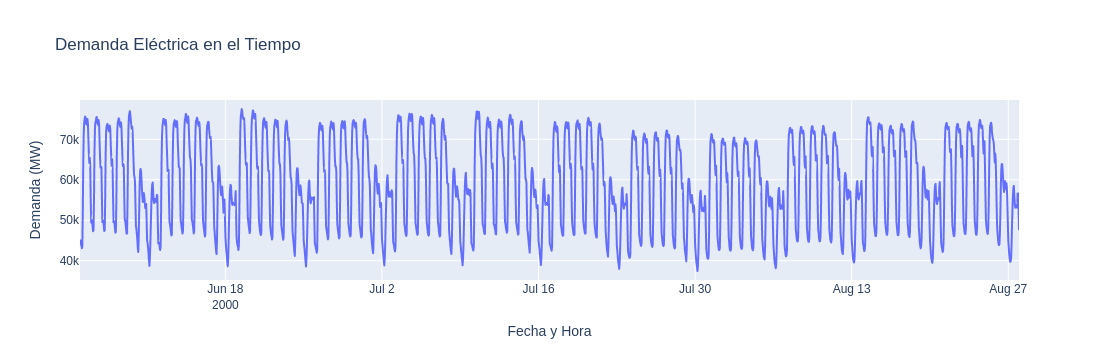

In [19]:
fig = px.line(electric_demand, x='Datetime', y='Demand', 
              labels={'Datetime': 'Fecha y Hora', 'Demand': 'Demanda (MW)'},
              title='Demanda Eléctrica en el Tiempo')
fig.show()

El segundo es una serie temporal sintética que nos va a permitir observar particularidades de las librerías.

In [20]:
causal_data = pd.read_csv("../data/time-series/causal_data.csv")

y = causal_data.iloc[:, 1]
x = causal_data.index


#y = electric_demand.iloc[:, 1]
#x = electric_demand.index

causal_data

,Fecha,Variable1,Variable2,Variable3,Variable4
0,2020-01-01,0.176405,0.627412,0.761009,0.997118
1,2020-01-02,0.216421,0.722421,1.038026,-1.136771
2,2020-01-03,0.314295,0.707285,1.156616,0.902540
3,2020-01-04,0.538384,0.696963,1.091042,-1.285689
4,2020-01-05,0.725140,0.738023,1.101357,0.310303
...,...,...,...,...,...
826,2022-04-06,-5.564356,0.176405,0.684709,0.379731
827,2022-04-07,-5.341762,0.216421,0.779456,0.820990
828,2022-04-08,-5.204663,0.314295,0.778471,-0.354884
829,2022-04-09,-5.255647,0.538384,0.759910,-0.308657


Esta serie tiene una variable indicando la fecha, y otras 4 variables, de las que utilizaremos la primera.

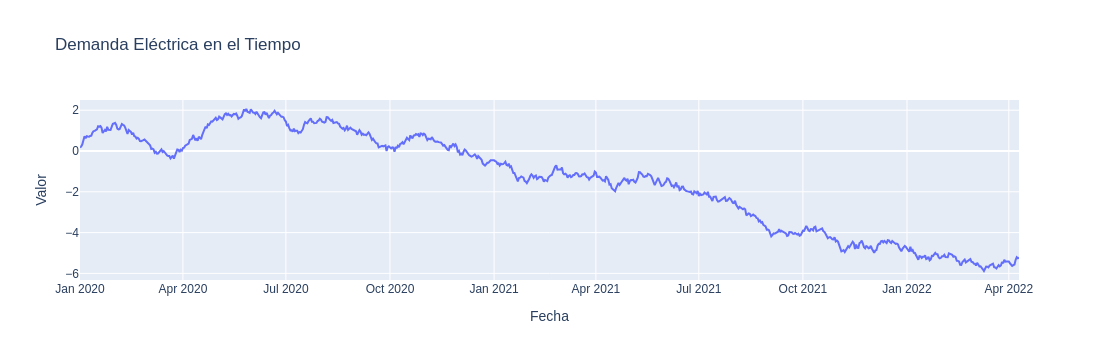

In [21]:
fig = px.line(causal_data, x='Fecha', y='Variable1', 
              labels={'Fecha': 'Fecha', 'Variable1': 'Valor'},
              title='Variable de dataset causal')
fig.show()

## Stumpy

STUMPY es una librería de Python que utiliza el algoritmo STOMP para analizar series temporales. Esta herramienta genera el matrix profile para encontrar subsecuencias y sus vecinos más cercanos. Su objetivo es ofrecer una interpretación fácil, ser independiente del tipo de datos y del perfil del usuario, y funcionar sin la necesidad de ajustes de parámetros.

El algoritmo STOMP (Scalable Time Series Motif Discovery) es una técnica que forma parte de la familia de algoritmos de matrix profile, diseñados para encontrar patrones repetitivos, llamados "motifs", en series temporales. A través del proceso de construcción de matrix profiles, STOMP puede descubrir estructuras subyacentes en los datos, como repeticiones periódicas, tendencias y anomalías.

El matrix profile es, básicamente, un vector de distancias euclídeas z-normalizadas, entre todas las subsecuencias de una serie temporal.

En la imagen inferior se puede ver un ejemplo de como se consigue la distancia euclídea por pares. Se escoge un tamaño de subsecuencia, **m**, en este caso 4, y se calcula distancia euclídea entre los pares de la serie.

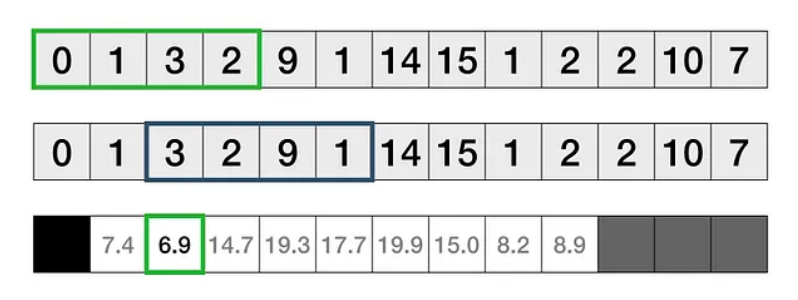

El matrix profile sale de hacer el cálculo anterior para todos los pares. Hacer todos estos cálculos con fuerza bruta escala mal, debido a que el aumentar ligeramente la longitud de la serie temporal a analizar, tiene como consecuencia grandes cambios en la cantidad de cálculos a realizar. Ahí es donde surge el algoritmo STOMP, para calcular la matrix profile de manera que acarree una complejidad muy inferior.

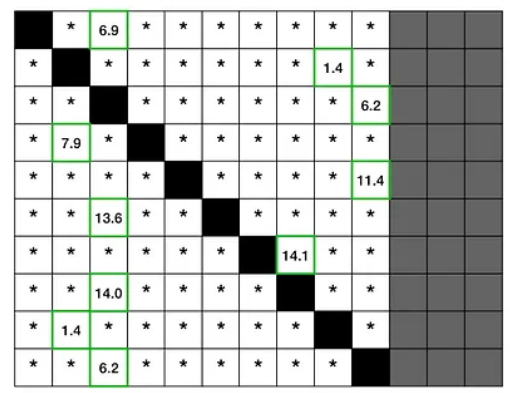

Los motifs de series temporales son subsecuencias parecidas repetidas que se encuentran dentro de una serie temporal más larga. Para poder encontrar el mejor motif, primero hace falta especificar el argumento m, es decir, la longitud del motif o subsecuencia que se va a buscar.

In [22]:
m = 50  #longitud de las subsecuencias

Primero se utiliza la libreria stumpy para calcular el matrix profile de la variable en cuestión.

In [23]:
matrix_profile = stumpy.stump(y, m)
matrix_profile_df = pd.DataFrame(matrix_profile,
                                 columns=['profile', 'profile index', 'left profile index', 'right profile index'])

Con la función *graph_matrix_profile* se puede visualizar la matrix profile. Esta crea una gráfica que permite visualizar los valores de la matrix profile a lo largo de la serie, aquí valores mayores significan que su vecino más cercano se parece menos

In [8]:
def graph_matrix_profile(x, y, best_motifs, profile_df, m):
    
    fig = make_subplots(rows=1, cols=1, shared_xaxes=False, vertical_spacing=0.08)
    fig.add_trace(go.Scatter(x=profile_df.index, y=profile_df['profile'], mode='lines'), row=1,
                  col=1)
    for idx in best_motifs.index:
        fig.add_shape(
            type="line",
            x0=idx, y0=min(profile_df['profile']), x1=idx, y1=max(profile_df['profile']),
            line=dict(color="orange"),
            row=1, col=1
        )
    fig.update_layout(height=400, grid=dict(rows=1, columns=1))
    fig.add_annotation(text="Matrix Profile", xref="paper", yref="paper", x=0.5, y=1.23, showarrow=False)
    fig.show()

**Mejor motif**

Los mejores motifs son las posiciones de la matrix_profile donde la distancia del perfil es mínima, es decir, los patrones son más similares. El mejor motif indica el par de subsecuencias de la serie temporal con mayor similitud.

In [9]:
best_motifs = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
profile_df = matrix_profile_df[['profile']]

En la siguiente celda se grafica el Matrix Profile, es decir, la distancia mínima con otra subsecuencia de cada subsecuencia. Las líneas amarillas señalan las subsecuencias con mejor distancia.

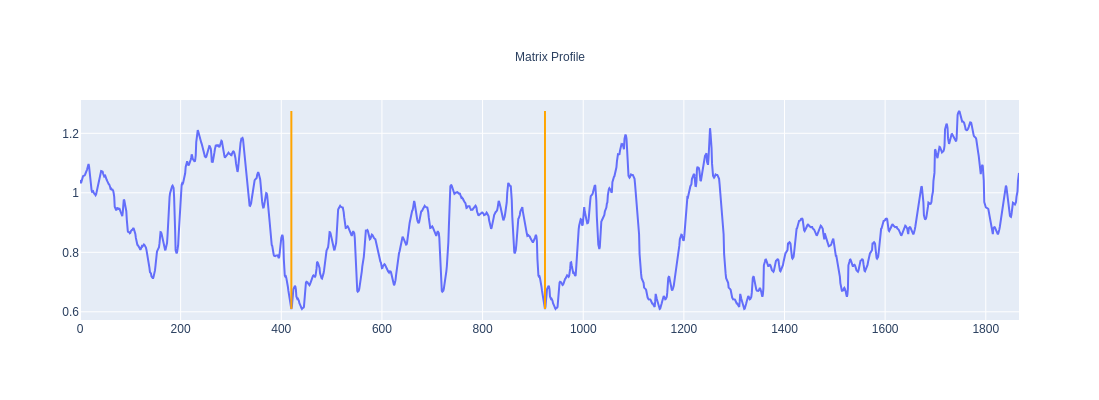

In [10]:
graph_matrix_profile(x, y, best_motifs, profile_df, m)

In [11]:
def graph_best_motif(x, y, best_motifs, m):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=False, vertical_spacing=0.08)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines'), row=1, col=1)
    colors = ['green', 'red']
    for i, color in enumerate(colors):
        idx = best_motifs.index[i]
        fig.add_shape(type="line", x0=x[idx], y0=min(y), x1=x[idx], y1=max(y),
                      line=dict(color=color), row=1, col=1)
        fig.add_shape(type="rect", x0=x[idx], y0=min(y), x1=x[idx] + m, y1=max(y),
                      fillcolor=color, opacity=0.5, row=1, col=1)   
    fig.update_layout(height=400, grid=dict(rows=1, columns=1))
    fig.add_annotation(text="Mejor motif", xref="paper", yref="paper", x=0.5, y=1.23, showarrow=False)
    fig.show()

En la gráfica de abajo se pueden ver las dos subsecuencias de longitud 50 más parecidas dentro de la serie temporal.

In [12]:
graph_best_motif(x, y, best_motifs, m)

**Mejor motif ampliado**

Para asegurarnos de que estos dos motifs realmente se parecen, la función *graph_amplified_best_motifs* compara de forma más ampliada los dos motifs más similares, como se puede ver en la gráfica, estos dos motifs realmente sí son muy similares.

In [13]:
def graph_amplified_best_motif(x, y, best_motifs, m):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=False, vertical_spacing=0.08)
    for idx in best_motifs.index:
        plot_y = y[idx:(idx + m)]
        fig.add_trace(go.Scatter(x=list(range(m)), y=plot_y, mode='lines'), row=1, col=1)
    fig.add_annotation(text="Comparativa ampliada del mejor motif", xref="paper", yref="paper", x=0.5, y=1.23,
                       showarrow=False)
    fig.update_layout(height=400, grid=dict(rows=1, columns=1))
    fig.update_traces(showlegend=False)
    fig.show()
    
    
graph_amplified_best_motif(x, y, best_motifs, m)

**Localizar la ventana más anómala**

La ventana más anómala es la que máxima la distancia respecto al resto de subsecuencias.

In [14]:
def graph_anomalous_window(x, y, matrix_profile_df, m):
    profile_df = matrix_profile_df[['profile']]
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines'), row=1, col=1)
    discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
    fig.add_shape(
        type="rect",
        x0=discord.index[0], y0=min(y), x1=discord.index[0] + m, y1=max(y),
        fillcolor="red", opacity=0.4,
        row=1, col=1
    )
    fig.add_shape(
        type="line",
        x0=discord.index[0], y0=min(y), x1=discord.index[0], y1=max(y),
        line=dict(color="red"),
        row=1, col=1
    )
    fig.add_trace(go.Scatter(x=profile_df.index, y=profile_df['profile'], mode='lines'), row=2, col=1)
    largest_discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
    fig.add_shape(
        type="line",
        x0=largest_discord.index[0], y0=min(profile_df['profile']), x1=largest_discord.index[0],
        y1=max(profile_df['profile']),
        line=dict(color="blue"),
        row=2, col=1
    )
    fig.update_layout(height=600, grid=dict(rows=2, columns=1))
    fig.update_traces(showlegend=False)
    fig.add_annotation(text="Ventana más anómala", xref="paper", yref="paper", x=0.5, y=1.05, showarrow=False)
    fig.add_annotation(text="Matrix Profile", xref="paper", yref="paper", x=0.5, y=0.48, showarrow=False)
    fig.show()

graph_anomalous_window(x, y, matrix_profile_df, m)

**Cadenas**

Las cadenas de series temporales son motifs que evolucionan y derivan con el tiempo. Una cadena de series temporales puede verse como un conjunto de motifs que coinciden estrechamente en alguna dirección. Abajo puede verse un ejemplo de esto con el dataset causal_data.

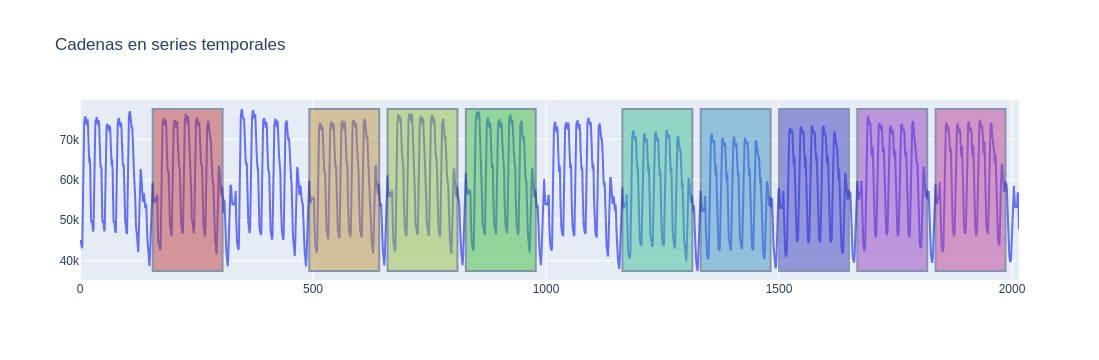

In [15]:
def graph_cadenas(y, matrix_profile, m):
    all_chain_set, unanchored_chain = stumpy.allc(matrix_profile[:, 2], matrix_profile[:, 3])
    num_colors = len(unanchored_chain)
    color_palette = ["hsl(" + str(h) + ",50%" + ",50%)" for h in np.linspace(0, 360, num_colors, endpoint=False)]
    fig = go.Figure()
    x_range = list(range(len(y)))
    fig.add_trace(go.Scatter(x=x_range, y=y, mode='lines'))
    for idx, color in zip(unanchored_chain, color_palette):
        fig.add_shape(
            type="rect",
            x0=idx, y0=min(y), x1=idx + m, y1=max(y),
            fillcolor=color, opacity=0.5
        )
    fig.update_layout(
        title="Cadenas en series temporales")
    fig.show()

graph_cadenas(y, matrix_profile, m)

## Fast Fourier Transform (FFT)

La FFT es una versión rápida y mejorada de la Transformada de Fourier discreta que permite analizar señales a lo largo del tiempo. Es útil en el procesado de señal gracias a su capacidad para descubrir las frecuencias ocultas que forman una señal.

**CARGAR LOS DATOS**

In [16]:
#data_array = causal_data['Variable1'].to_numpy()
data_array = electric_demand['Demand'].to_numpy()

Primero se aplica la transformada rápida de Fourier a la variable en cuestión, y se genera un array de esta longitud.

In [17]:
N = len(data_array)
fft_result = fft(data_array)
num_fft_points = len(fft_result)
frequency_indices = np.arange(N)

NameError: name 'N' is not defined

Para poder hacer la FFT es necesario conocer el intervalo de muestreo a la que se obtuvieron los datos. Si el intervalo es cada segundo, la tasa de muestreo, sr, será 1, sin embargo para otras frecuencias de sampleo como días, horas o minutos es diferente.

In [18]:
# sampling rate
dia = 60*60*24
hora = 60*60
minuto = 60

Abajo obtenemos la tasa de muestreo como el recíproco del intervalo de muestreo. total_duration representa la duración del periodo y frequency_values es el rango posible de frecuencias.

In [19]:
sr = 1 / hora
total_duration = num_fft_points/sr
frequency_values = frequency_indices/total_duration 

NameError: name 'frequency_indices' is not defined

f_oneside representa la parte positiva del array de frecuencias. Se escoge solo la parte positiva para evitar redundancia ya que al aplicar la FFT a una señal real, el espectro en el dominio de la frecuencia es simétrico alrededor de la frecuencia cero. 

In [20]:
n_oneside = num_fft_points//2
f_oneside = frequency_values[:n_oneside]

NameError: name 'frequency_values' is not defined

In [21]:
X = fft_result[:n_oneside]

Este gráfico muestra el espectro de amplitud positivo de la señal tras aplicar la transformada rápida de Fourier (FFT). El eje X representa las frecuencias positivas y el eje Y muestra la amplitud de cada componente de frecuencia.

In [22]:
fig = px.line(x=f_oneside, y=np.abs(fft_result[:n_oneside]), 
              labels={'x': 'Frecuencia (Hz)', 'y': 'Amplitud de la FFT |X(freq)|'})
fig.update_layout(width=1200, height=600)
fig.show()

Se puede ver el resultado de la FFT en dominio temporal para poder sacar más conclusiones, para ello se calcula period_in_time, un array que dice cuánto tiempo corresponde a cada frecuencia del espectro.

In [23]:
period_in_time = 1/f_oneside / dia

/tmp/ipykernel_66898/3622268443.py:1: RuntimeWarning:

divide by zero encountered in true_divide



En la gráfica de electric_demand podemos ver picos de amplitud en 1 y 7 cuando la frecuencia de reconstrucción es de días. Esto quiere decir que hay patrones que se repiten cada día y cada semana. La frecuencia de reconstrucción no tiene porque ser la misma que la tasa de sampleo.

In [24]:
fig = go.Figure(go.Scatter(x=period_in_time, y=np.abs(X[:n_oneside]) / n_oneside, mode='lines'))

fig.update_xaxes(title_text='Period ($day$)')
fig.update_yaxes(title_text='Amplitud')

fig.update_layout(width=1200, height=400)

fig.show()

**Quitar ruido a señales estacionales**

La FFT facilita la identificación de las frecuencias que corresponden a ruidos no deseados. Una vez calculada la FFT de la señal, es posible aplicar filtros en el dominio de la frecuencia para eliminar o atenuar los componentes de frecuencia asociados al ruido. Por ejemplo, un filtro de paso bajo permite atenuar los componentes de alta frecuencia. El ruido puede manifestarse como fluctuaciones aleatorias en el dominio del tiempo, y analizando la señal en el dominio de la frecuencia es posible aislar los componentes de ruido de las señales de interés.

A continuación haremos una demostración de como quitar ruido a una señal, para lo que previamente introduciremos ruido en los datasets que estábamos utilizando.

In [25]:
df = electric_demand[:500]
columna = 'Demand'

In [26]:
ruido = 1800

Para introducir ruido aleatorio simplemente añadimos una amplitud cada instante siguiendo una distribución normal.

In [27]:
df_ruido = df.copy()
df_ruido[columna] += np.random.normal(0, ruido, size=df.shape[0])

La función denoise_signal elimina el ruido de una señal aplicando un filtro de frecuencia. Primero, convertimos la señal al dominio de la frecuencia con la FFT. Luego, se eliminan las componentes de frecuencia superiores al umbral especificado (cutoff_freq). Finalmente, see aplica la transformada inversa de Fourier (IFFT) para volver al dominio del tiempo y devolver la señal suavizada en la columna original.

In [28]:
def denoise_signal(data,column, cutoff_freq):   
    fft_result = np.fft.fft(data[column])
    fft_result_filtered = fft_result.copy()
    fft_result_filtered[(cutoff_freq + 1):(-cutoff_freq)] = 0
    data_denoised = np.fft.ifft(fft_result_filtered)
    data[column] = data_denoised
    return data

In [29]:
def plot_signal(data, column, titulo):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(len(data[column])), y=np.real(data[column]), mode='lines', name='Señal'))
    fig.update_layout(title='Señal' +titulo, xaxis_title='Tiempo', yaxis_title='Amplitud')
    fig.show()

fc es la frecuencia de corte. la frecuencia de corte es el punto en el espectro de frecuencias donde el filtro comienza a atenuar las frecuencias no deseadas.

In [30]:
fc = 155
df_demanda_denoised = denoise_signal(df_ruido.copy() ,columna, fc)

En la gráfica inferior se pueden ver la señal original, la señal después de introducirle el ruido y la señal a la que se le quitó el ruido utilizando la FFT.

In [31]:
plot_signal(df,columna," original") #original
plot_signal(df_ruido, columna, " ruidosa") #con ruido
plot_signal(df_demanda_denoised,columna, " limpia") #sin ruido